In [2]:
import pandas as pd

raw_df = pd.read_feather("../data/data.feather")
test_items_df = pd.read_csv("../data/test_items.csv",index_col=0)
question_data = pd.read_csv("../data/question_data.csv", sep=';', index_col=0)

In [3]:
test_item_qs = [item for item in test_items_df.index if item in raw_df.columns]

In [4]:
q_df = raw_df.drop(columns=test_item_qs)
q_df = q_df.filter(regex=r'^q\d+$')

In [5]:
# drop the lowest response q's
N_DROP = 2000
low_response = [col for col in question_data.sort_values('N').iloc[:N_DROP].index if col in q_df.columns]
q_df = q_df.drop(columns=low_response)

In [6]:
# sort by number of categories for easier manipulation later
sorted_num_levels = q_df.apply(lambda x: len(x.cat.categories)).sort_values()
q_df = q_df[sorted_num_levels.index]

In [7]:
# Get the number of unique levels per column
num_levels = q_df.nunique()

# Sort columns by unique levels
sorted_num_levels = num_levels.sort_values()

# Find the indices where the level count changes
level_counts = sorted_num_levels.values
diff = level_counts[1:] != level_counts[:-1]
border_indices = list(diff.nonzero()[0] + 1)  # +1 because diff is between elements

# For example, print the borders and corresponding levels
print("Border indices where level count changes:", border_indices)
print("Levels at borders:", level_counts[border_indices])

# You can use these indices to split the sorted columns into dfs as needed

Border indices where level count changes: [np.int64(252), np.int64(392)]
Levels at borders: [3 4]


In [8]:
import numpy as np

non_nan = ~q_df.isna()
non_nan_indices = np.flatnonzero(non_nan.values)

np.random.seed(0)
TEST_SIZE = 0.2
test_size = int(len(non_nan_indices) * TEST_SIZE)
test_mask_flat = np.random.choice(non_nan_indices, size=test_size, replace=False)

test_mask = np.zeros_like(q_df.values, dtype=bool)
test_mask.flat[test_mask_flat] = True

# mask some cells that serve as our test set
df_masked = q_df.mask(test_mask)


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), q_df.columns),
    ],
    sparse_threshold=1.0
)

def transform_and_drop(df):
    X = preprocessor.fit_transform(df)

    # the sklearn onehot encoder doesn't have an option to not encode nans
    feature_names = preprocessor.get_feature_names_out()
    cols_to_keep = [i for i, name in enumerate(feature_names) if not name.endswith('_nan')]
    X = X[:, cols_to_keep]
    return X

X_combined = transform_and_drop(df_masked)

In [10]:
import numpy as np
from scipy import sparse

# Original mask (shape: n_users x n_original_questions)

# convert the original mask to a mask over the onehots
def expand_mask(mask):
    mask_expanded = []
    for col_idx, col in enumerate(q_df.columns):
        n_categories = len(q_df[col].cat.categories)
        # Repeat mask along a new axis (shape: n_users x n_categories)
        mask_repeated = np.repeat(mask[:, col_idx][:, np.newaxis], n_categories, axis=1)
        mask_expanded.append(mask_repeated)
        # sanity check
        assert mask_repeated.shape[0] == 68371

    # Stack horizontally (shape: n_users x n_encoded_features)
    mask_expanded = np.hstack(mask_expanded)
    return mask_expanded

# Convert to sparse matrix (if X_combined is sparse)
test_mask_expanded = expand_mask(test_mask)
test_mask_sparse = sparse.csr_matrix(test_mask_expanded)

original_mask = expand_mask(non_nan.values)

In [11]:
# sanity check

print(test_mask_sparse.shape, X_combined.shape)
X_combined[test_mask_sparse.nonzero()].any()

(68371, 1660) (68371, 1660)


np.False_

### data cleaned, ready for naive bayes

In [12]:
pr_q_answered = df_masked.notna().mean()
pr_user_answered = df_masked.notna().mean(axis=1)

In [13]:
feature_names = preprocessor.get_feature_names_out()

In [14]:
feature_names = preprocessor.get_feature_names_out()
kept_features = [item[8:].split('_') for item in feature_names if not item.endswith('_nan')]

In [15]:
# demonstration of how the naive imputation model works

for user, feature in zip(*test_mask_sparse.nonzero()):
    question, option = kept_features[feature]
    print(user, question, option)
    print("pr(user answers)=", pr_user_answered[user])
    print("pr(question gets answered)=", pr_q_answered[question])
    print("pr(option i selected | question K gets answered)=", df_masked[question].value_counts(normalize=True)[option])
    print("take the prodcut of these")
    break

0 q136 No
pr(user answers)= 0.3177083333333333
pr(question gets answered)= 0.4242588231852686
pr(option i selected | question K gets answered)= 0.38135622435963734
take the prodcut of these


In [16]:
questions = np.array([q for q, o in kept_features])
options   = np.array([o for q, o in kept_features])

option_probs = {
    q: df_masked[q].value_counts(normalize=True).reindex(q_df[q].cat.categories, fill_value=0)
    for q in q_df.columns
}
option_probs_df = pd.DataFrame(option_probs).T  # index: question, columns: option. super redundant but helps vectorize the operations below

users_idx, features_idx = test_mask_sparse.nonzero()

q_for_masked = questions[features_idx]
o_for_masked = options[features_idx]

pr_user_vals = pr_user_answered.values[users_idx]
pr_q_vals    = pr_q_answered[q_for_masked].values
pr_option_vals = option_probs_df.values[
    option_probs_df.index.get_indexer(q_for_masked),
    option_probs_df.columns.get_indexer(o_for_masked)
]

# Vectorized naive bayes
naive_imputed_values = pr_user_vals * pr_q_vals * pr_option_vals


In [17]:
# compare hidden test values to real values
X_not_masked = transform_and_drop(q_df)

# check:
X_not_masked.shape == X_combined.shape

True

In [18]:
# MSE
mse_naive = (np.asarray(X_not_masked[test_mask_sparse] - naive_imputed_values).ravel()**2).mean()
mse_naive

np.float64(0.2730330339564801)

In [19]:
# this is the one that Yoram explained to me, but I think the one above makes more sense.

row_mean = X_combined.mean(axis=1).ravel()
col_mean = X_combined.mean(axis=0).ravel()

naive_imputation2 = np.asarray(row_mean).ravel()[users_idx] * np.asarray(col_mean).ravel()[features_idx]

mse_naive2 = (np.asarray(X_not_masked[test_mask_sparse] - naive_imputation2).ravel()**2).mean()
mse_naive2

np.float64(0.31851035178195297)

### imputing values randomly

In [20]:
# random
mse_random = (np.asarray(X_not_masked[test_mask_sparse] - np.random.uniform(size=naive_imputed_values.shape)).ravel() **2).mean()
mse_random

np.float64(0.3334513101328833)

In [21]:
# impute as as constant, mean of test data:

train_data = X_not_masked[original_mask & ~test_mask_sparse.toarray()]
mean_val = train_data.mean()

mse_constant = (np.asarray(X_not_masked[test_mask_sparse] - (np.zeros_like(naive_imputed_values) + mean_val)).ravel() **2).mean()
mse_constant

np.float64(0.22649856560228354)

### imputing as modal answer

In [22]:
def get_mode(series):
    return series.mode().iloc[0]

df_modal_imputed = df_masked.apply(lambda col: col.fillna(get_mode(col)))
X_modal = transform_and_drop(df_modal_imputed)

In [23]:
# MSE
mse_modal = (np.asarray(X_not_masked[test_mask_sparse] - X_modal[test_mask_sparse]).ravel() **2).mean()
mse_modal

np.float64(0.2541229049423542)

### low rank approximation method!

In [27]:
import torch
import torch.optim as optim
import torch.nn.functional as F

# Convert sparse matrices to PyTorch tensors
X_combined_tensor = torch.tensor(X_combined.toarray(), dtype=torch.float32)
test_mask_tensor = torch.tensor(test_mask_sparse.toarray(), dtype=torch.bool)
train_mask_tensor = torch.tensor(original_mask, dtype=torch.bool) & ~test_mask_tensor

# Hyperparameters
rank = 5  # Rank of the approximation (adjust as needed)
learning_rate = 0.1
epochs = 5

# Initialize low-rank matrices B and C
n_users, n_features = X_combined.shape
B = torch.randn(n_users, rank, requires_grad=True)
C = torch.randn(rank, n_features, requires_grad=True)
X_hat = torch.mm(B, C)

# Optimizer
optimizer = optim.Adam([B, C], lr=learning_rate)

@torch.compile
def split_and_softmax(X):
    split_sizes = [border_indices[0]] + \
                [border_indices[i+1] - border_indices[i] for i in range(len(border_indices)-1)] + \
                [q_df.shape[1] - border_indices[-1]]

    split_sizes = [item * (i+2) for i, item in enumerate(split_sizes)]
    split_tensors = torch.split(X, split_sizes, dim=1)

    processed_tensors = []
    for i, tensor in enumerate(split_tensors):
        options_per_question = 2 + i  # 2 for first split, 3 for second, 4 for third
        n_questions = tensor.shape[1] // options_per_question
        
        # Reshape to (n_users, n_questions, options_per_question)
        reshaped = tensor.view(-1, n_questions, options_per_question)
        
        # Apply softmax along the last dimension
        softmaxed = F.softmax(reshaped, dim=-1)
        processed_tensors.append(softmaxed)
    
    flattened_tensors = [tensor.view(tensor.shape[0], -1) for tensor in processed_tensors]
    X_softmaxed = torch.cat(flattened_tensors, dim=1)
    return X_softmaxed

# Training loop
@torch.compile
def train_loop():
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Reconstruct X_hat = B @ C
        X_hat = torch.mm(B, C)
        X_hat = split_and_softmax(X_hat) # this is the right inductive bias and it also dratically lowers the loss

        # Compute loss only on observed entries (not masked for testing)
        loss = torch.mean((X_hat[train_mask_tensor] - X_combined_tensor[train_mask_tensor]) ** 2)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch}, Loss: {loss.item()}")
    return X_hat

X_hat = train_loop()


W0416 08:45:26.256000 12511 site-packages/torch/_logging/_internal.py:1089] [2/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Epoch 0, Loss: 0.31707778573036194
Epoch 1, Loss: 0.2988622486591339
Epoch 2, Loss: 0.2818002998828888
Epoch 3, Loss: 0.2666385769844055
Epoch 4, Loss: 0.2537580728530884


In [28]:

# After training, use X_hat to impute missing values
X_imputed = X_hat.detach().numpy()

# Evaluate on test set
test_values = np.asarray(X_not_masked[test_mask_sparse])
imputed_test_values = X_imputed[test_mask_sparse.toarray()]

mse_low_rank = ((test_values - imputed_test_values) ** 2).mean()
print(f"Low-rank MSE: {mse_low_rank}")

Low-rank MSE: 0.2571645045890882


### autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_combined_tensor = torch.tensor(X_combined.toarray(), dtype=torch.float32)
original_mask_tensor = torch.tensor(original_mask, dtype=torch.float32)
test_mask_tensor = torch.tensor(test_mask_sparse.toarray(), dtype=torch.float32)

# Create a training mask: original data present but not in test set
train_mask_tensor = original_mask_tensor * (1 - test_mask_tensor)

# Autoencoder architecture (same as before)
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Hyperparameters
input_dim = X_combined_tensor.shape[1]
encoding_dim = 64
batch_size = 256
learning_rate = 0.001
epochs = 5

# Create the autoencoder model
model = Autoencoder(input_dim, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader
dataset = TensorDataset(X_combined_tensor, train_mask_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_train_mask in dataloader:
        # Forward pass
        outputs = model(batch_x)
        
        # Compute loss only on non-masked, non-test values
        loss = criterion(outputs * batch_train_mask, batch_x * batch_train_mask)
        loss = loss / batch_train_mask.sum()  # Normalize by number of non-masked elements
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_train_mask.sum()
    
    avg_loss = total_loss / train_mask_tensor.sum()
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/5], Average Loss: 0.1508
Epoch [2/5], Average Loss: 0.1304
Epoch [3/5], Average Loss: 0.1233
Epoch [4/5], Average Loss: 0.1183
Epoch [5/5], Average Loss: 0.1143


AttributeError: 'matrix' object has no attribute 'toarray'

In [33]:

# Use the trained model for imputation
model.eval()
with torch.no_grad():
    imputed_data = model(X_combined_tensor)

# Extract imputed values for the test set
imputed_test_values = imputed_data[test_mask_tensor.bool()].numpy()
true_test_values = np.asarray(X_not_masked[test_mask_sparse])

# Compute MSE for the autoencoder method
mse_autoencoder = ((true_test_values - imputed_test_values) ** 2).mean()
print(f"Autoencoder MSE: {mse_autoencoder}")

Autoencoder MSE: 0.13427468260616784


### autoencoder without minibatching

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Convert data to PyTorch tensors (if not already done)
X_combined_tensor = torch.tensor(X_combined.toarray(), dtype=torch.float32)
original_mask_tensor = torch.tensor(original_mask, dtype=torch.float32)
test_mask_tensor = torch.tensor(test_mask_sparse.toarray(), dtype=torch.float32)

# Create a training mask: original data present but not in test set
train_mask_tensor = original_mask_tensor * (1 - test_mask_tensor)

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Softmax function (same as in low-rank approximation)
@torch.compile
def split_and_softmax(X):
    split_sizes = [border_indices[0]] + \
                [border_indices[i+1] - border_indices[i] for i in range(len(border_indices)-1)] + \
                [q_df.shape[1] - border_indices[-1]]

    split_sizes = [item * (i+2) for i, item in enumerate(split_sizes)]
    split_tensors = torch.split(X, split_sizes, dim=1)

    processed_tensors = []
    for i, tensor in enumerate(split_tensors):
        options_per_question = 2 + i  # 2 for first split, 3 for second, 4 for third
        n_questions = tensor.shape[1] // options_per_question
        
        # Reshape to (n_users, n_questions, options_per_question)
        reshaped = tensor.view(-1, n_questions, options_per_question)
        
        # Apply softmax along the last dimension
        softmaxed = F.softmax(reshaped, dim=-1)
        processed_tensors.append(softmaxed)
    
    flattened_tensors = [tensor.view(tensor.shape[0], -1) for tensor in processed_tensors]
    X_softmaxed = torch.cat(flattened_tensors, dim=1)
    return X_softmaxed

# Hyperparameters
input_dim = X_combined_tensor.shape[1]
encoding_dim = 64
learning_rate = 0.001
epochs = 1  # Increase epochs since we're not minibatching

# Create the autoencoder model
model = Autoencoder(input_dim, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_combined_tensor)
    outputs_softmax = split_and_softmax(outputs)
    
    # Compute loss only on non-masked, non-test values
    loss = criterion(outputs_softmax * train_mask_tensor, X_combined_tensor * train_mask_tensor)
    loss = loss / train_mask_tensor.sum()  # Normalize by number of non-masked elements
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Use the trained model for imputation
model.eval()
with torch.no_grad():
    imputed_data = model(X_combined_tensor)
    imputed_data_softmax = split_and_softmax(imputed_data)

# Extract imputed values for the test set
imputed_test_values = imputed_data_softmax[test_mask_tensor.bool()].numpy()
true_test_values = np.asarray(X_not_masked[test_mask_sparse])

# Compute MSE for the autoencoder method
mse_autoencoder = ((true_test_values - imputed_test_values) ** 2).mean()
print(f"Autoencoder MSE: {mse_autoencoder}")

Autoencoder MSE: 0.2129213418300474


### compare MSE's

/var/folders/9d/j5yw54ld78qdvpkxky67ldz40000gn/T/ipykernel_12511/290987678.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=e_series.index, y=e_series.values, palette='viridis')


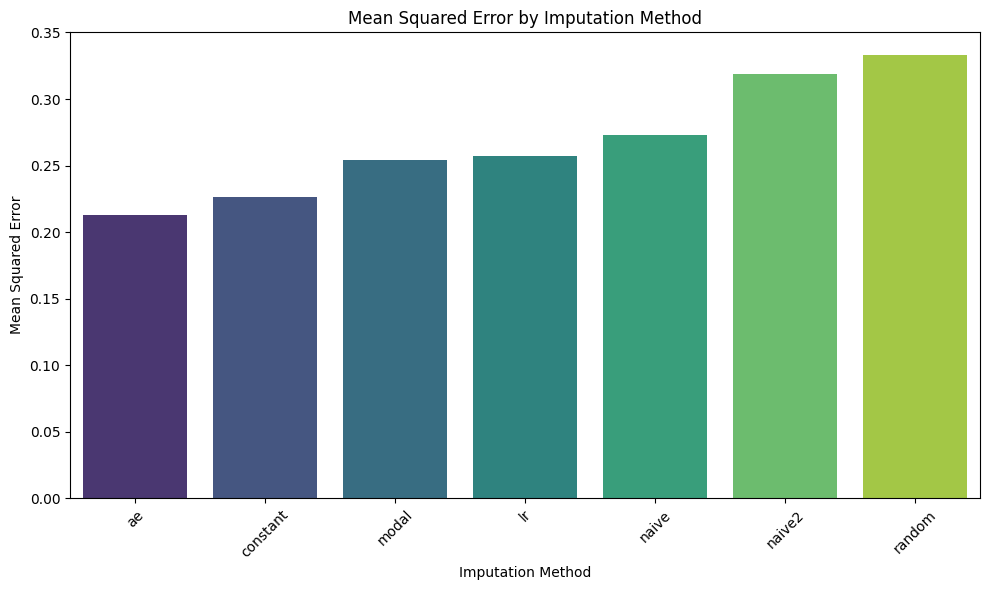

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

errors = {"autoencoder": mse_autoencoder,
'constant': mse_constant,
'lowrank': mse_low_rank,
'modal': mse_modal,
'naive': mse_naive,
'naive2': mse_naive2,
'random': mse_random}

e_series = pd.Series(errors).sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=e_series.index, y=e_series.values, palette='viridis')
plt.title('Mean Squared Error by Imputation Method')
plt.xlabel('Imputation Method')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()